# Proyecto de desarrollo de sistema de IA basado en alquileres de pisos – Tercera fase

## 1. Creación del entorno
### 1.1 Instalación de dependencias en Kaggle

In [1]:
!pip install spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.1 MB/s eta 0:00:00:00:010:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### 1.2 Importación de dependencias

In [4]:
# ——— Librerías estándar ———
import re
import string
from collections import Counter

# ——— Manipulación de datos ———
import numpy as np
import pandas as pd

# ——— Visualización ———
import matplotlib.pyplot as plt
import seaborn as sns

# ——— NLP ———
import nltk
from nltk.corpus import stopwords
import spacy

# ——— Deep Learning & Transformers ———
import torch
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup,
)

# ——— Gensim ———
from gensim.models import Word2Vec

# ——— TensorFlow / Keras ———
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping, 
    ModelCheckpoint
)
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    GlobalMaxPooling1D,
    MaxPooling1D,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# ——— Scikit‑learn ———
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.pipeline import Pipeline

print("Imports Ok")


2025-04-20 20:04:13.906425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745179453.929930    4089 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745179453.937114    4089 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imports Ok


### 1.3 Carga del Dataset

In [8]:
df = pd.read_csv('/kaggle/input/idealista-madrid/Datos.csv')

In [9]:
df.shape
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11826 entries, 0 to 11825
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   provincia       11826 non-null  object 
 1   zona            11826 non-null  object 
 2   titulo          11826 non-null  object 
 3   PrecioActual    11826 non-null  int64  
 4   PrecioAnterior  11826 non-null  int64  
 5   metros          11826 non-null  int64  
 6   habitaciones    11460 non-null  float64
 7   ascensor        11033 non-null  object 
 8   localizacion    10730 non-null  object 
 9   planta          10601 non-null  object 
 10  baños           11826 non-null  int64  
 11  tags            11664 non-null  object 
 12  descripcion     11761 non-null  object 
 13  Enlace          11826 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 1.3+ MB


provincia            0
zona                 0
titulo               0
PrecioActual         0
PrecioAnterior       0
metros               0
habitaciones       366
ascensor           793
localizacion      1096
planta            1225
baños                0
tags               162
descripcion         65
Enlace               0
dtype: int64

## 2. Preprocesamiento

#### 2.1 Se crea un dataset solo con precio y descripción, quitando los nulos.

In [10]:
df = df.dropna(subset=['descripcion'])
df = df[['descripcion', 'PrecioActual']].rename(columns={'PrecioActual': 'price', 'descripcion': 'description'}) 
df.head()


,description,price
0,Particular Vende vivienda totalmente reformada...,355000
1,Inmobiliarias Encuentro vende en exclusiva la ...,149000
2,ESTUDIO EN PLENO CENTRO DE MADRIDSarago Servic...,195000
3,"Esta acogedora vivienda, ubicada en una planta...",195000
4,"Maravilloso ATICO de reciente construcción, co...",715000


#### 2.2 Se cargan las stopwords y limpiamos el texto.


In [11]:
# nltk.download('stopwords') // no podemos cargar las stopwords desde kaggle, lo haremos manual de "https://github.com/nltk/nltk_data/blob/gh-pages/packages/corpora/stopwords.zip"

spanish_stopwords = [
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 
    'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 
    'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 
    'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 
    'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 
    'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 
    'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 
    'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 
    'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 
    'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 
    'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 
    'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 
    'estés', 'estemos', 'estéis', 'estén', 'estaré', 'estarás', 'estará', 'estaremos', 
    'estaréis', 'estarán'
]

#### 2.3 Funciones de limpieza de texto

In [13]:
nlp = spacy.load('es_core_news_sm')

def normalizar_terminos_inmobiliaria(texto):
    # Normalizar unidades de medida
    texto = re.sub(r'\bm2\b|\bm²\b|\bmetros cuadrados\b|\bmetros 2\b',
                   'metros_cuadrados', texto)
    texto = re.sub(r'\bm\b|\bmetros\b', 'metro', texto)
    return texto

In [14]:
# Función ELIMINANDO STOPWORDS ('limpio')

def limpiar_texto(text):
    text = normalizar_terminos_inmobiliaria(text)
    text = text.lower() # conversión a minúsculas
    text = re.sub(r'\d+', '', text) # eliminar números
    text = text.translate(str.maketrans('', '', string.punctuation)) # eliminar puntuación
    text = re.sub(r'\s+', ' ', text) # eliminar espacions múltiples
    text = ' '.join([word for word in text.split() if word not in spanish_stopwords]) # eliminar stopwords
    return text.strip()

df['limpio'] = df['description'].apply(limpiar_texto)

print("ok")

ok


In [15]:
# Función con LEMATIZACIÓN ('lematizado')


def limpiar_texto_basico(text):
    text = normalizar_terminos_inmobiliaria(text)
    text = text.lower()  # Conversión a minúsculas
    text = re.sub(r'\d+', '', text)  # Eliminación de números
    text = text.translate(str.maketrans('', '', string.punctuation))  # Eliminación de signos de puntuación
    text = re.sub(r'\s+', ' ', text)  # Eliminación de espacios múltiples
    return text.strip()


def limpiar_texto_con_lematizacion(text):
    text = limpiar_texto_basico(text) # Separación de las funciones para tener flexibilidad probando los diferentes modelos

    doc = nlp(text) # Lematización con Spacy
    
    # Extracción de lemas
    palabras_lematizadas = []
    for token in doc:
        if token.text not in spanish_stopwords and not token.is_punct: # Filtro de Stopwords y puntuación
            palabras_lematizadas.append(token.lemma_) # Añade el lema
    
    text = ' '.join(palabras_lematizadas) # juntamos los lemas separados por espacio
    
    return text.strip() # Eliminamos espacios a inicio y final

df['lematizado'] = df['description'].apply(limpiar_texto_con_lematizacion)

print("ok")


ok


In [16]:
# Ejemplo tras el preprocesado incluyendo metros / m2
texto_ejemplo = (
    "Piso de 120 m2 en el centro, con 3 habitaciones y 2 baños. "
    "La superficie útil son 110 metros cuadrados. "
    "Totalmente reformado, con acabados de LUJO y buenas vistas."
)

print("Texto original:")
print(texto_ejemplo)

print("\nTexto limpio básico (con normalización y eliminación de stopwords):")
print(limpiar_texto(texto_ejemplo))

print("\nTexto con lematización (tras limpieza básica):")
print(limpiar_texto_con_lematizacion(texto_ejemplo))

# Ejemplo real del dataset
print("\n\nEjemplo del dataset real (índice 5):")
ejemplo_idx = 5  # Cambia este índice según tus datos
print("Original:", df['description'].iloc[ejemplo_idx][:150], "...")
print("Limpio:", df['limpio'].iloc[ejemplo_idx][:150], "...")
print("Lematizado:", df['lematizado'].iloc[ejemplo_idx][:150], "...")

print("\nok")


Texto original:
Piso de 120 m2 en el centro, con 3 habitaciones y 2 baños. La superficie útil son 110 metros cuadrados. Totalmente reformado, con acabados de LUJO y buenas vistas.

Texto limpio básico (con normalización y eliminación de stopwords):
piso metroscuadrados centro habitaciones baños superficie útil son metroscuadrados totalmente reformado acabados lujo buenas vistas

Texto con lematización (tras limpieza básica):
piso metroscuadrado centro habitación baño superficie útil ser metroscuadrado totalmente reformado acabado lujo buena visto


Ejemplo del dataset real (índice 5):
Original: Un lugar que te cambiará la vida.Magnifico proyecto de obra nueva de Darya Homes en en una ubicación privilegiada, entre el Palacio Real, Madrid Río y ...
Limpio: lugar cambiará vidamagnifico proyecto obra nueva darya homes ubicación privilegiada palacio real madrid río latinaevela es edificio viviendas todas ex ...
Lematizado: lugar cambiar vidamagnifico proyecto obra nuevo darya homes ubicació

Promedio de palabras - Original: 49.90
Promedio de palabras - Limpio: 29.24
Promedio de palabras - Lematizado: 29.31
Reducción - Limpio vs Original: 41.39%
Reducción - Lematizado vs Original: 41.25%


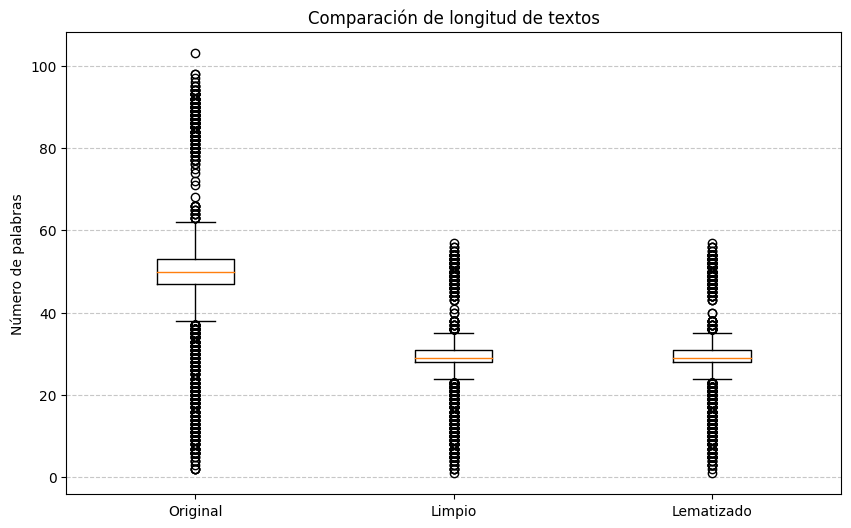

ok


In [17]:
# Comparación de longitud de textos
longitud_original = df['description'].apply(lambda x: len(x.split()))
longitud_limpio = df['limpio'].apply(lambda x: len(x.split()))
longitud_lematizado = df['lematizado'].apply(lambda x: len(x.split()))

print(f"Promedio de palabras - Original: {longitud_original.mean():.2f}")
print(f"Promedio de palabras - Limpio: {longitud_limpio.mean():.2f}")
print(f"Promedio de palabras - Lematizado: {longitud_lematizado.mean():.2f}")
print(f"Reducción - Limpio vs Original: {100*(1-longitud_limpio.mean()/longitud_original.mean()):.2f}%")
print(f"Reducción - Lematizado vs Original: {100*(1-longitud_lematizado.mean()/longitud_original.mean()):.2f}%")

# Visualización
plt.figure(figsize=(10, 6))
plt.boxplot([longitud_original, longitud_limpio, longitud_lematizado], 
            labels=['Original', 'Limpio', 'Lematizado'])
plt.title('Comparación de longitud de textos')
plt.ylabel('Número de palabras')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("ok")

#### Entre el texto limpio y el lematizado la diferencia es mínima. Lo cual es lógico. Lo importante aquí es que reducen el promedio de palabras entorno a un 41% respecto al original

In [18]:

# Función para obtener las palabras más frecuentes
def palabras_frecuentes(textos, n=20):
    contador = Counter()
    for texto in textos:
        contador.update(texto.split())
    return contador.most_common(n)

# Palabras más frecuentes en cada versión
palabras_limpio = palabras_frecuentes(df['limpio'])
palabras_lematizado = palabras_frecuentes(df['lematizado'])

print("Top 20 palabras más frecuentes - Limpio:")
for palabra, frecuencia in palabras_limpio:
    print(f"{palabra}: {frecuencia}")
    
print("\nTop 20 palabras más frecuentes - Lematizado:")
for palabra, frecuencia in palabras_lematizado:
    print(f"{palabra}: {frecuencia}")

print("ok")

Top 20 palabras más frecuentes - Limpio:
piso: 7178
vivienda: 5978
metroscuadrados: 5055
madrid: 3687
planta: 3345
cocina: 3310
dormitorios: 3110
barrio: 3078
zona: 3034
salón: 2886
dos: 2756
calle: 2561
exterior: 2499
ofrece: 2479
cuenta: 2444
baño: 2272
es: 2158
reformado: 1886
inmueble: 1841
edificio: 1820

Top 20 palabras más frecuentes - Lematizado:
piso: 7345
vivienda: 6854
metroscuadrado: 5051
zona: 4632
dormitorio: 3966
baño: 3821
madrid: 3698
planta: 3656
ser: 3401
barrio: 3287
amplio: 3096
salón: 2962
calle: 2922
ofrecer: 2920
cocina: 2886
dos: 2756
exterior: 2667
reformado: 2650
ubicado: 2583
contar: 2477
ok


#### Se observa que "m", "m2", "metros" y "metros cuadrados" son palabras que aluden al mismo concepto. Este hecho puede ser interesante unificarlo y ver si los modelos mejoran.

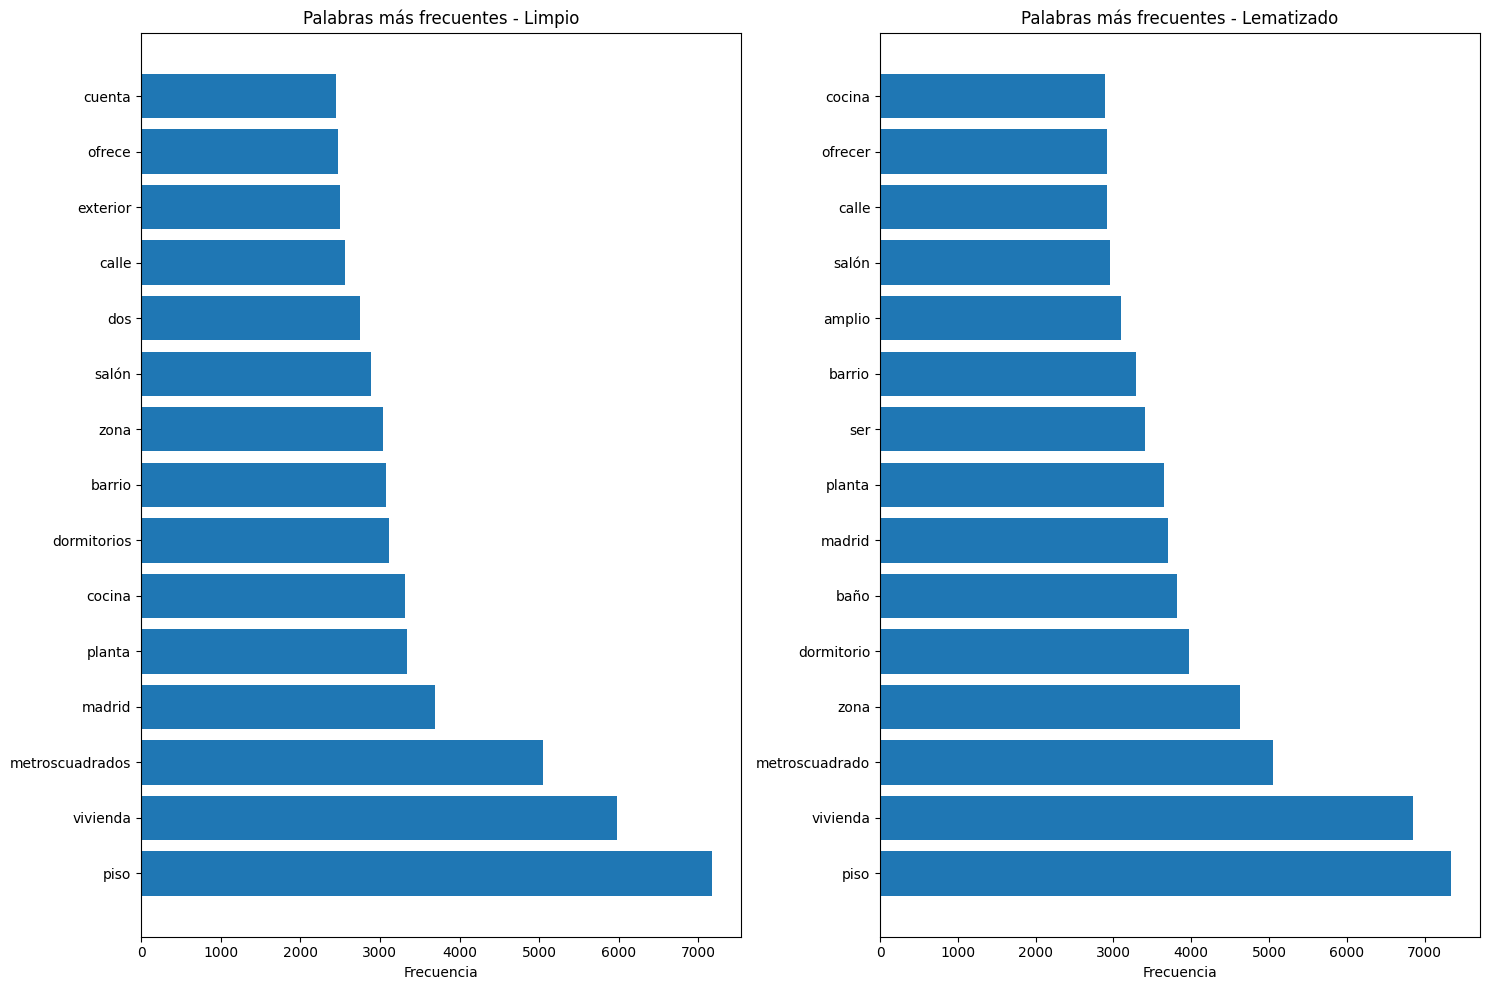

In [19]:
# Graficamos
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.barh([p[0] for p in palabras_limpio[:15]], [p[1] for p in palabras_limpio[:15]])
plt.title('Palabras más frecuentes - Limpio')
plt.xlabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.barh([p[0] for p in palabras_lematizado[:15]], [p[1] for p in palabras_lematizado[:15]])
plt.title('Palabras más frecuentes - Lematizado')
plt.xlabel('Frecuencia')

plt.tight_layout()
plt.show()

## TF-IDF + Lasso con GridSearch (Frecuencia de término + Regresión Lineal)

In [20]:
# División de datos
X = df['limpio']
y = df['price']

X_train_texts, X_test_texts, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creación de pipeline con TF-IDF y modelo de regresión
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('regressor', Lasso(max_iter=5000))  # Lasso: regresión lineal con regularización L1 // # Añado max_iter para reducir advertencias de convergencia
])

# Definición del grid de parámetros a explorar
param_grid = {
    'tfidf__max_features': [3000],  # Número de términos a considerar. Extenso: [3000, 5000] 
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams y bigrams
    'tfidf__min_df': [5, 10],  # Frecuencia mínima de aparición
    'regressor__alpha': [0.01, 0.1]  # Parámetro de regularización reducidos para Lasso. Para la versión final usar: [0.001, 0.01, 0.1]
}

print("Iniciando GridSearchCV")
    
# Crear y ejecutar GridSearchCV
grid_search = GridSearchCV(
    pipeline, param_grid, 
    cv=2,  # 3-fold cross-validation 
    scoring='neg_mean_absolute_error',  # Se optimiza para MAE
    verbose=1,  # Mostrar progreso
    n_jobs=-1  # Se utilizan todos los cores disponibles
)

# Entrenamiento con GridSearch
grid_search.fit(X_train_texts, y_train)

# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Predicción y evaluación con el mejor modelo
y_pred = best_model.predict(X_test_texts)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\nTF-IDF + GridSearch -> MAE:", mae)
print("TF-IDF + GridSearch -> MSE:", mse)

Iniciando GridSearchCV
Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 256702908512855.56, tolerance: 639013982150.7725
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 457939747027973.8, tolerance: 769121079513.8888
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 325693603339913.9, tolerance: 769121079513.8888
  model = cd_fast.sparse_enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:592: Converg


Mejores parámetros encontrados:
regressor__alpha: 0.1
tfidf__max_features: 3000
tfidf__min_df: 10
tfidf__ngram_range: (1, 1)

TF-IDF + GridSearch -> MAE: 626807.9504577954
TF-IDF + GridSearch -> MSE: 1046026283757.8763


In [21]:
# 1) Convertir resultados del GridSearchCV a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# 2) Calcular MAE positivo y ordenar
results_df['MAE'] = -results_df['mean_test_score']
results_df = results_df.sort_values(by='MAE')

# 3) Mostrar los 5 ajustes de parámetros con mejor MAE
display(results_df[['params', 'MAE']].head())


,params,MAE
6,"{'regressor__alpha': 0.1, 'tfidf__max_features...",659665.381278
2,"{'regressor__alpha': 0.01, 'tfidf__max_feature...",659880.366336
4,"{'regressor__alpha': 0.1, 'tfidf__max_features...",843895.289705
0,"{'regressor__alpha': 0.01, 'tfidf__max_feature...",845783.489578
7,"{'regressor__alpha': 0.1, 'tfidf__max_features...",996854.374752


#### Notas para TF-IDF + regresor
- Preprocesado con Tokenización + Lematización con NLTK
- Eliminación de stopwords en español
- Normalización de términos específicos del sector inmobiliario para el área de un inmueble
- Se incorpora GridSearchCV para mejorar la combinación de hiperparámetros
- Usamos LASSO para reducir la complejidad del modelo. Útil para datasets con alta dimensionalidad.

#### Configuración óptima encontrada con GridSearchCV:

Hiperparámetros TF-IDF:

max_features: 3000 (límite de términos considerados)
min_df: 10 (términos presentes en al menos 10 documentos)
ngram_range: (1,1) (solo unigramas)


Hiperparámetros Lasso:

alpha: 0.1 (nivel de regularización óptimo)

## Modelo Word2Vec + CNN // (Word embedding)

In [42]:
# Tokenización de los textos (listas de palabras)
tokenized_texts = [text.split() for text in df['lematizado']]

# Entrenamos Word2Vec con nuestro corpus
embedding_dim = 200
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Creamos el diccionario que asigna a cada palabra un número
word_index = {word: i+1 for i, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1 # El 0 se usa para padding

# Inicializamos la matriz con ceros y shape "(vocab_size, embedding_dim)"
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Llenamos la matriz con los vectores preentrenados
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

# Tokenización
tokenizer = Tokenizer()
tokenizer.word_index = word_index
sequences = tokenizer.texts_to_sequences(df['lematizado'])

# Padding
max_len = 100  # Longitud máxima de secuencia
X_pad = pad_sequences(sequences, maxlen=max_len)
print("Forma de X_pad:", X_pad.shape)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_pad, df['price'], test_size=0.2, random_state=42)
print("Forma de X_train:", X_train.shape)

print("ok")


Forma de X_pad: (11761, 100)
Forma de X_train: (9408, 100)
ok


In [44]:


model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                 output_dim=embedding_dim,
                 weights=[embedding_matrix],
                 input_length=max_len,
                 trainable=False)) # Con False se usan vectores genéricos

model.add(SpatialDropout1D(0.2))

# Usamos convoluciones múltiples
model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization()) # 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization()) # 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization()) # 
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization()) # 
#model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

model.add(Dense(128, activation='relu')) # No se normaliza; preservamos distribución de la última activación
model.add(Dropout(0.2))  # Prevención de overfitting
model.add(Dense(1)) # Salida contínua

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.build(input_shape=(None, max_len))
model.summary()

print("ok")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 200)            │       3,882,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_7                  │ (None, 100, 200)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 100, 64)             │          38,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 100, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_36 (Conv1D)                   │ (None, 50, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 50, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 25, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 25, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_38 (Conv1D)                   │ (None, 12, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ (None, 12, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │              

 Total params: 4,157,089 (15.86 MB)

 Trainable params: 273,665 (1.04 MB)

 Non-trainable params: 3,883,424 (14.81 MB)

ok


In [45]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,               # 3 épocas sin mejora
    restore_best_weights=True # recarga los pesos del mejor punto
)
checkpt = ModelCheckpoint(
    'mejor_cnn.keras',
    monitor='val_loss',
    save_best_only=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # Reducción del lr (0.001 en Adam por defecto) para ajustar al lr óptimo del del BatchNorm
    patience=2,         # 2 épocas sin mejora
    min_lr=1e-6
)

history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.2,
    callbacks=[early_stop, checkpt, reduce_lr]
)

loss, mae = model.evaluate(X_test, y_test)

print("Word2Vec + CNN -> MAE:", mae)
print("Word2Vec + CNN -> MSE (aproximado):", loss)


Epoch 1/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - loss: 2605900890112.0000 - mae: 1023831.8125 - val_loss: 2170287816704.0000 - val_mae: 984723.8750 - learning_rate: 0.0010
Epoch 2/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2581409038336.0000 - mae: 1015344.6250 - val_loss: 2101194784768.0000 - val_mae: 959955.5625 - learning_rate: 0.0010
Epoch 3/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2493779017728.0000 - mae: 985442.4375 - val_loss: 1964663635968.0000 - val_mae: 905495.0000 - learning_rate: 0.0010
Epoch 4/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2317777371136.0000 - mae: 924950.8750 - val_loss: 1817871384576.0000 - val_mae: 844898.8750 - learning_rate: 0.0010
Epoch 5/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2051200516096.0000 - mae: 833211.2500 - val_loss: 1448375877632.0000 - val_mae: 675868.1875 - learning_rate: 0.0010
Epoch 6/30
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1717479931904.0000 - mae: 723010.5625 - val_loss: 129183

#### Notas para Word2Vec + CNN
- Se utiliza Batch Normalization tras cada capa convolucional para estabilizar el fit y acelerar la convergencia.
- Se aplica BatchNorm a cada capa pero finalmente se elimina la aplicación en la capa densa para evitar aplanar la salida
-  Se aplica ModelCheckpoint para salvar la mejor versión.
-  Se incorpora EarlyStopping para detener cuando deja de mejorar con patience=3
-  ReduceLROnPlateau ajusta el LR a la mitad tras dos épocas (patience=2)

#### Arquitectura
- Embeddings pre-entrenados para aportar contexto específico del uso del idioma. Esto beneficia la precisión del modelo.
- Se congelan para acelerar el fit, al evitar sobreajustes.
- Se usan 5 capas convolucionales con número de filtros y tamaños de kernel:
- 64 filtros, kernel=3
- 64 filtros, kernel=3
- 128 filtros, kernel=5
- 128 filtros, kernel=5
- 128 filtros, kernel=5
- Se propone usar 64 filtros en la 1ª y 2ª capa y 128 en las siguientes para arrancar de forma liger ay mejorar de forma progresiva.
- La función de activación es ReLU, seguida de Dropout(0.2) para evitar overfitting.
- Word2Vec + CNN -> MAE: 529405.875

## Modelo BERT/transformer

In [28]:
# Preprocesamiento específico para BERT
def preprocess_text_for_bert(text):
    # Limpieza básica manteniendo la estructura sintáctica
    text = text.lower()  # Minúsculas
    text = re.sub(r'\s+', ' ', text)  # Eliminar espacios múltiples
    text = re.sub(r'[^\w\s.,;:!?¿¡()]', '', text)  # Mantener puntuación básica, eliminar caracteres extraños
        
    max_words = 200  # Se considera un límite de 512 tokens para BERT
    words = text.split()
    if len(words) > max_words:
        text = ' '.join(words[:max_words])
        
    return text.strip()

# Aplicar el preprocesamiento y crear una nueva columna
df['bert_processed'] = df['description'].apply(preprocess_text_for_bert)

# Estadísticas del resultado
avg_len = df['bert_processed'].apply(lambda x: len(x.split())).mean()
print(f"Longitud media (palabras): {avg_len:.2f}")
print(f"Ejemplo de texto procesado:\n{df['bert_processed'].iloc[0][:300]}...")

Longitud media (palabras): 49.74
Ejemplo de texto procesado:
particular vende vivienda totalmente reformada, cocina independiente, salón, dos dormitorios y un baño. amplias vistas a zonas ajardinadas y portero físico.todas las ventanas dan al exterior, muy luminoso y soleado, sin ruidos de la calle.características generales: suelos porcelánicos imitación márm...


In [29]:
modelo_transformer = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(modelo_transformer)

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(df['bert_processed'], df['price'], test_size=0.2, random_state=42)

# Dataset personalizado para regresión
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, targets):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=64)
        self.labels = targets.tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [53]:
# 1. Se crea el modelo
model = AutoModelForSequenceClassification.from_pretrained(modelo_transformer, num_labels=1)


# 2. Se crea el dataset. En este punto la plataforma (kaggle) colapsa y se prueban diversos tamaños para prubas.

# Limitar a 1000 ejemplos para pruebas iniciales
# train_subset = [train_dataset[i] for i in range(min(1000, len(train_dataset)))]
# test_subset = [test_dataset[i] for i in range(min(200, len(test_dataset)))]

# Datasets pequeños para pruebas
# train_small_dataset = train_subset
# test_small_dataset = test_subset

# Dataset Mediano para ejemplos
train_medium = [train_dataset[i] for i in range(min(5000, len(train_dataset)))]
test_medium = [test_dataset[i] for i in range(min(1000, len(test_dataset)))]

# Dataset medianos para pruebas
train_medium_dataset = train_medium
test_medium_dataset = test_medium

# 3. Cálculo de steps para el scheduler
train_steps = len(train_medium) * 5 // 8  # epochs * examples / batch_siz
warmup_steps = int(train_steps * 0.1)  # 10% de warmup

# 4. Se crea Optimizer y Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=warmup_steps,
    num_training_steps=train_steps
)

# 5. Se definen los argumentos para el el fit
training_args = TrainingArguments(
    output_dir="./resultados_transformer",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    report_to="none",logging_steps=50,  # Frecuencia para ver el proceso
    save_strategy="no",  # No para horrar tiempo/espacio
    fp16=True,  # True para acelerar el entrenamiento
    warmup_ratio=0.1,  #Calentamiento gradual del learning rate 
    weight_decay=0.01,  # Regularización para evitar overfitting
    
)


# 6. Diagnóstico
print(f"Dataset original: {len(train_dataset)} ejemplos de entrenamiento, {len(test_dataset)} ejemplos de prueba")
# print(f"Dataset reducido: {len(train_small_dataset)} ejemplos de entrenamiento, {len(test_small_dataset)} ejemplos de prueba")
print(f"Dataset mediano: {len(train_medium_dataset)} ejemplos de entrenamiento, {len(test_medium_dataset)} ejemplos de prueba")

# 7. Definimos trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_medium_dataset,
    eval_dataset=test_medium_dataset,
    optimizers=(optimizer, scheduler),  # Añadimos optimizer y scheduler

)

# Diagnóstico 2
print(f"BERT model: {modelo_transformer}")
print(f"Tamaño del batch: {training_args.per_device_train_batch_size}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Dispositivo disponible: {'GPU' if torch.cuda.is_available() else 'CPU'}")
if torch.cuda.is_available():
    print(f"Nombre GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Memoria GPU disponible: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB usados")
print("Iniciando entrenamiento...")


trainer.train()

print("⚙️ Entrenamiento completado.")

eval_results = trainer.evaluate()
print("Transformers -> Eval:", eval_results)
results = trainer.evaluate()
print(results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dataset original: 9408 ejemplos de entrenamiento, 2353 ejemplos de prueba
Dataset mediano: 5000 ejemplos de entrenamiento, 1000 ejemplos de prueba
BERT model: dccuchile/bert-base-spanish-wwm-uncased
Tamaño del batch: 8
Epochs: 5
Dispositivo disponible: GPU
Nombre GPU: Tesla T4
Memoria GPU total: 15.83 GB
Memoria GPU disponible: 0.46 GB usados
Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,2006109766287.360107
100,3161757958799.359863
150,2798802855526.399902
200,2576769320222.720215
250,2801453991198.720215
300,2656802848112.640137
350,2893123189473.279785
400,3357990988021.759766
450,2302363691909.120117
500,2320249881886.720215


⚙️ Entrenamiento completado.


Transformers -> Eval: {'eval_loss': 3095199744000.0, 'eval_runtime': 4.0846, 'eval_samples_per_second': 244.821, 'eval_steps_per_second': 15.424, 'epoch': 5.0}
{'eval_loss': 3095199744000.0, 'eval_runtime': 4.0737, 'eval_samples_per_second': 245.474, 'eval_steps_per_second': 15.465, 'epoch': 5.0}


In [54]:
resultados = pd.DataFrame({
    'Modelo': ['TF-IDF + Lasso', 'Word2Vec + CNN', 'BERT (Transformer)'],
    'MAE': [626807.95, 529405.87, float(eval_results.get('eval_loss', 0)**0.5)],  
    'MSE': [1.04e12, 1.62e12, eval_results.get('eval_loss', 0)], 
    'Tiempo de entrenamiento': ['25 min', '1 min', '5 min'],  #
    'Comentario': [
        'Sorprendentemente efectivo con GridSearch para ser un modelo tan básico',
        'Buen resultado, mejora bastante',
        'Mejor rendimiento con dataset mediano y fine-tuning'
    ]
})

display(resultados)


,Modelo,MAE,MSE,Tiempo de entrenamiento,Comentario
0,TF-IDF + Lasso,6.268079e+05,1.040000e+12,25 min,Sorprendentemente efectivo con GridSearch para...
1,Word2Vec + CNN,5.294059e+05,1.620000e+12,1 min,"Buen resultado, mejora bastante"
2,BERT (Transformer),1.759318e+06,3.095200e+12,5 min,Mejor rendimiento con dataset mediano y fine-t...


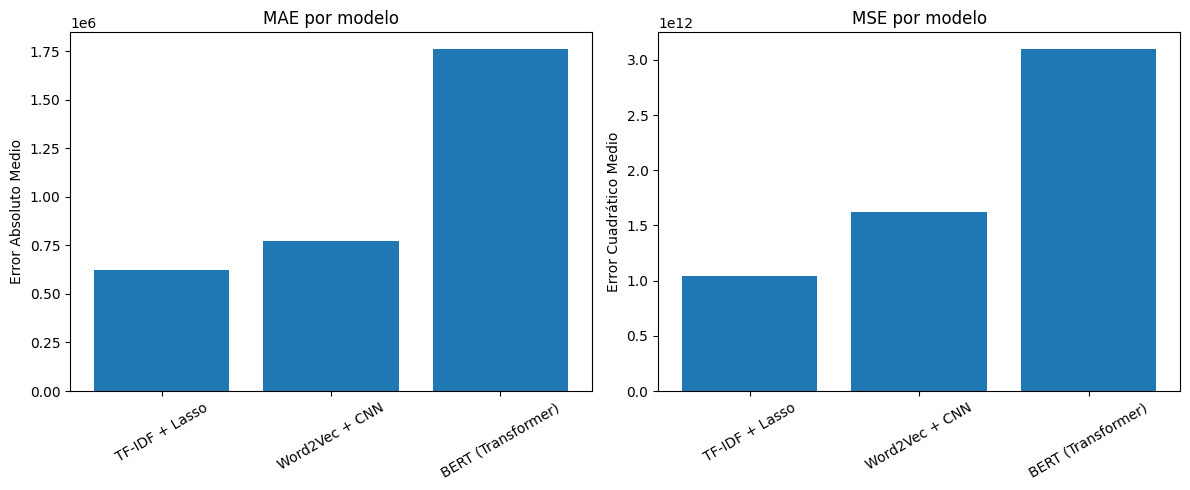

In [61]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico MAE
axes[0].bar(resultados['Modelo'], resultados['MAE'])
axes[0].set_title('MAE por modelo')
axes[0].set_ylabel('Error Absoluto Medio')
axes[0].tick_params(axis='x', rotation=30)

# Gráfico MSE
axes[1].bar(resultados['Modelo'], resultados['MSE'])
axes[1].set_title('MSE por modelo')
axes[1].set_ylabel('Error Cuadrático Medio')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()
